# Задание № 4

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]


План следующий:
- Скачать данные на локальную машину
- Отфильтровать по тегу "человек"
- загружать на colab





In [1]:
import os

import numpy as np
import skimage.io as io
import tensorflow as tf

In [2]:
%tensorflow_version 2.x


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Подготовка COCO

### Локальная настройка на Windows

Данные торрент-клиентом качал отсюда [Academic Torrents](https://academictorrents.com/details/74dec1dd21ae4994dfd9069f9cb0443eb960c962)
train2017.zip - 19 Гб
val2017.zip - 0.8 Гб
annotations_trainval2017.zip - 0.3 Гб

использовал альтернативный репозиторий
https://github.com/philferriere/cocoapi.git#egg=pycocotools

Установка Microsoft Visual C++ 14.0 or greater из [Microsoft C++ Build Tools](https://visualstudio.microsoft.com/ru/visual-cpp-build-tools/) 1,7 Г

### Подготовка COCO API

In [ ]:
# !cd PythonAPI
# !pip install Cython
# !pip install git+https://github.com/philferriere/cocoapi.git#egg=pycocotools^&subdirectory=PythonAPI

In [ ]:
from pycocotools.coco import COCO

In [ ]:
# COCO_ROOT = 'C:/prj/GeekBrainsAI/fast-ai-coco'

### Настройка на Colab

In [3]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2023-01-28 09:53:22--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.214.17, 52.217.70.4, 52.216.110.75, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.214.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  58.9MB/s    in 17m 34s 

2023-01-28 10:10:56 (17.5 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-01-28 10:10:56--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.196.41, 52.217.234.89, 54.231.202.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.196.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 7

### Подготовка COCO API

In [4]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else:  # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho + inp_size, wo:wo + inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_' + sublist + '2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

## Создание объектов Datasets

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [8]:
print(len(COCO_dataset_train.img_list), len(COCO_dataset_val.img_list))

64115 2693


In [9]:
train_ds = COCO_dataset_train.train_dataset(batch_size=16, epochs=5, inp_size=256)

In [10]:
val_ds = COCO_dataset_val.val_dataset(batch_size=16, inp_size=256)

In [11]:
type(val_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
print(len(train_ds), len(val_ds))

20035 168


### Исследование Datasets

In [12]:
for iteration, (images, labels) in enumerate(val_ds):
    break


#### Батч набора валидации

In [13]:
print(iteration, images.shape, labels.shape)

0 (16, 256, 256, 3) (16, 256, 256, 1)


#### Отображение элементов из выборки

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

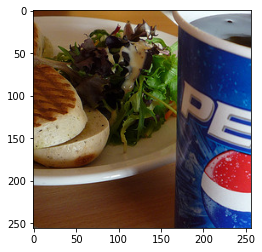

In [15]:
image = images[3, ...]
plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.show()

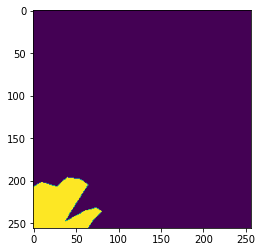

In [16]:
image = labels[2, ...]
# image = image[:,:,0]
plt.figure(figsize=(12, 4))
plt.imshow(image[:, :, 0])
plt.show()

#### Отображение набора с масками

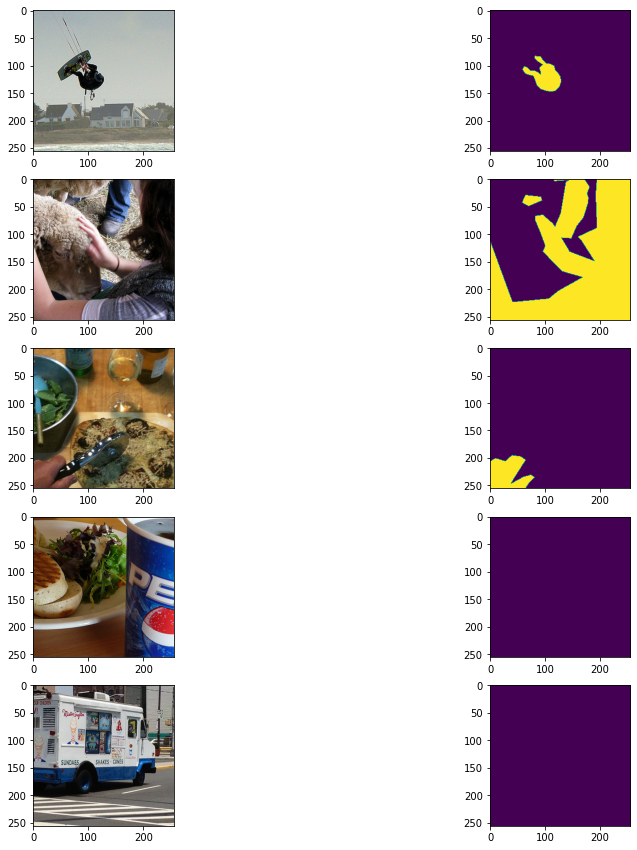

In [17]:
fig, ax = plt.subplots(5, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
k = 0
for idx in range(5):
    image = labels[idx, ...]
    ax[k][0].imshow(images[idx, ...], aspect=1)
    ax[k][1].imshow(image[:, :, 0], aspect=1)
    k += 1
plt.show()

#### Списки картинок

In [18]:
COCO_dataset_train.img_list[1:10]

[262146, 524291, 262148, 393223, 393224, 524297, 393227, 131084, 393230]

In [19]:
COCO_dataset_val.img_list[1:10]

[458755, 385029, 311303, 393226, 532493, 8211, 327701, 188439, 434204]

In [20]:
len(train_ds)

20035

### Сохранение батчей во внутреннем формате

In [ ]:
# val_ds.save('val_ds_save3', compression='GZIP')

In [ ]:
# train_ds.save('train_ds_save3', compression='GZIP')

## Построение модели U-Net

In [21]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

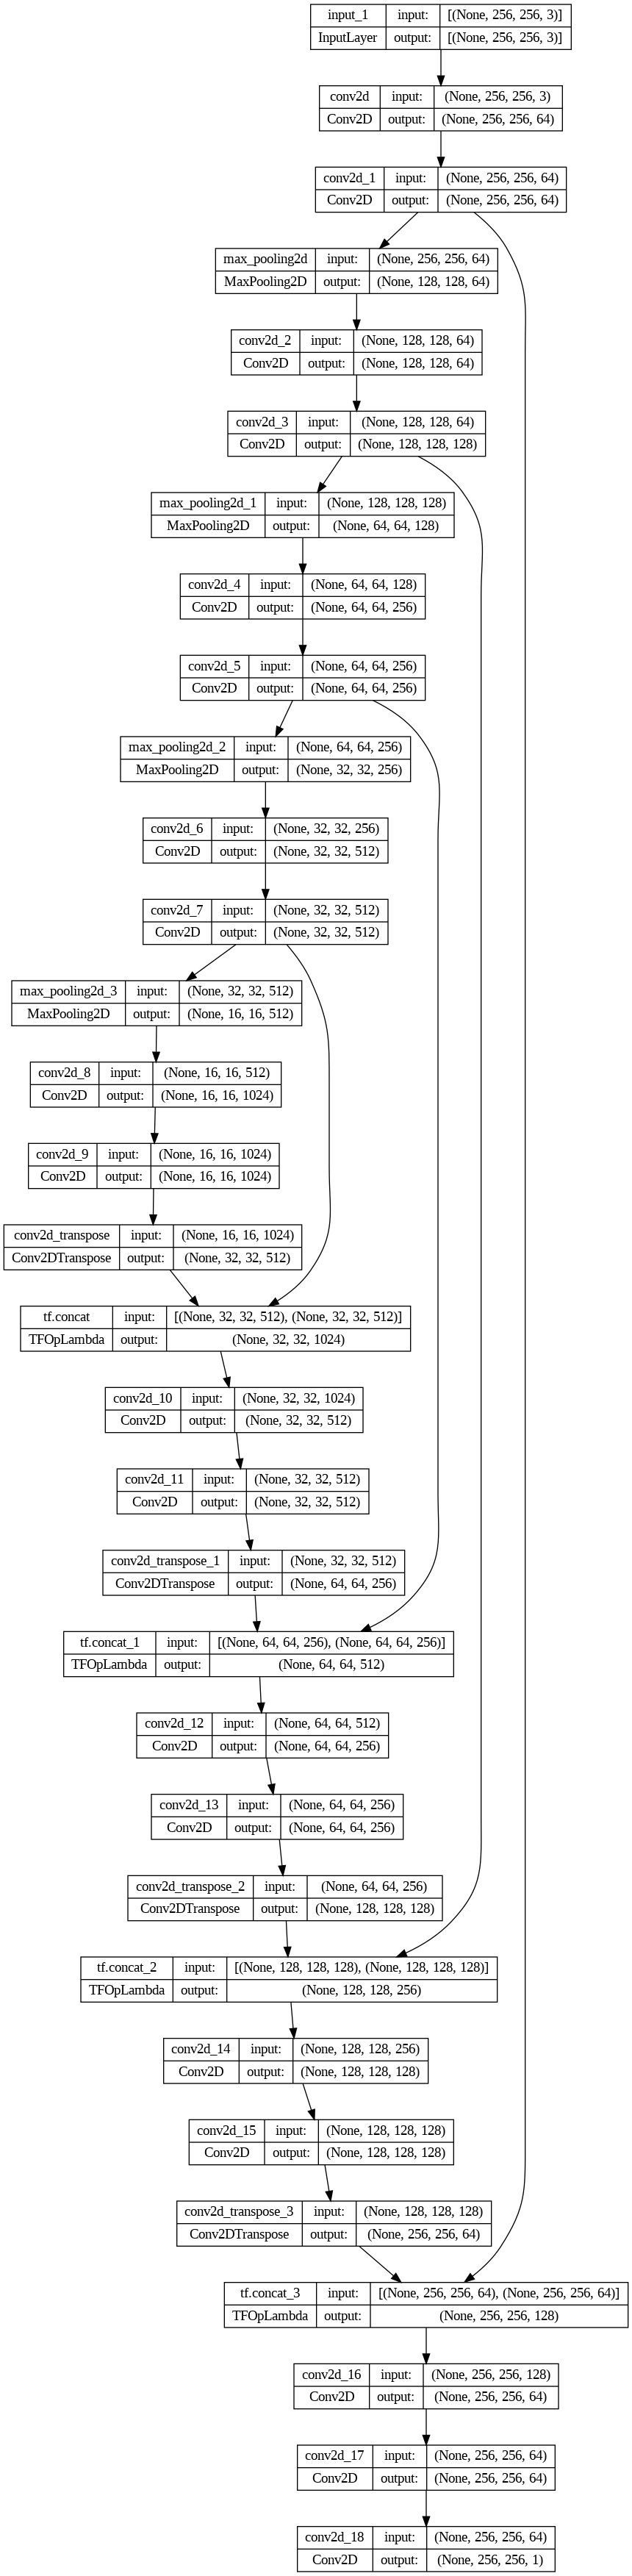

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)


## Подготовка модели

In [29]:
from tensorflow.python import metrics
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss,metrics=['accuracy'])

## Обучение модели

In [30]:
hist = model.fit(train_ds.take(500), validation_data=val_ds)

500/500 [==============================] - 604s 1s/step - loss: 0.4780 - accuracy: 0.7821 - val_loss: 0.5218 - val_accuracy: 0.7540


In [31]:
model.evaluate(val_ds.take(50))

50/50 [==============================] - 24s 477ms/step - loss: 0.5207 - accuracy: 0.7544


[0.5207052230834961, 0.7544344067573547]

## Вывод

> Удалось скачать и подготовить набор данных (изображение + маска) для создания модели для решения задачи сегментации.